In [1]:
!pip install scikit-learn seaborn matplotlib pandas numpy scikit-image pillow scikit-fuzzy

In [2]:
from PIL import Image, ImageOps
import skfuzzy as fuzz
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage.transform import resize
from skimage import color, io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, auc, silhouette_score, silhouette_samples, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.fftpack import rfft, irfft
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import pickle
import os

In [77]:
#source: https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
def fourier_transform(image):
    image = np.array(image)
    fourier_image = np.fft.fftshift(np.fft.fft2(image))
    return fourier_image

def filter_fourier_image(fourier_image, low_cutoff, high_cutoff):  
    # Create a mask for the desired frequency range
    rows, cols = fourier_image.shape
    crow, ccol = rows//2, cols//2
    
    # Create a grid of distances from the center
    x = np.arange(rows).reshape((rows, 1))  # column vector
    y = np.arange(cols).reshape((1, cols))  # row vector
    distances = np.sqrt((x - crow) ** 2 + (y - ccol) ** 2)

    # Create a bandpass filter mask
    mask = (distances > low_cutoff) & (distances < high_cutoff)
    filtered_image = fourier_image * mask

    return filtered_image

def inverse_fourier_transform(f_transform ):
    image = abs(np.fft.ifft2(f_transform))
    return image

# source: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html https://kushalvyas.github.io/BOV.html
def sift_features(images):
    descriptor_extractor = SIFT()
    sift_features = []

    for i, img in enumerate(images):
        print(f'{i} of {len(images)}')
        descriptor_extractor.detect_and_extract(img)
        descriptors = descriptor_extractor.descriptors
        if descriptors is not None:
            sift_features.append(descriptors)
            
    return sift_features


def bag_of_visual_words(sift_features, K):    
    # Concatenate all descriptors into a single array
    all_descriptors = np.vstack(sift_features)
    
    # set number of visual words 
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(all_descriptors)

    # Get the visual words (cluster centers)
    visual_words = kmeans.cluster_centers_
 
    histograms = []
    for i, descriptors in enumerate(sift_features):
        print(f'{i} of {len(sift_features)}')
        # Predict which visual word each descriptor belongs to
        if descriptors.size != 0:
            visual_word_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(visual_word_indices, bins=np.arange(K + 1))
            histograms.append(histogram)
        else:
            # Append a histogram of zeros if no descriptors found
            histograms.append(np.zeros(K))

    # Create Bag-of-Visual-Words histograms
    return np.array(histograms)


def plot_ROC(y_test, y_scores):
    n_classes = len(set(labels))
    mlb = MultiLabelBinarizer(classes=range(n_classes))  
    y_test = mlb.fit_transform(y_test.reshape(-1, 1))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

    mean_auc =  np.mean(list(roc_auc.values()))
    # Plot diagonal line (random chance)
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve, Mean AUC: {mean_auc:.2f}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


def fuzzy_clustering(data, title):
    #standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    n_clusters = 5  
    fuzziness = 1.5  # Fuzziness factor

    # Apply Fuzzy C-Means
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data.T, c=n_clusters, m=fuzziness, error=0.005, maxiter=1000)

    # Get cluster memberships and labels
    cluster_membership = np.argmax(u, axis=0)
    
    # Calculate silhouette scores
    sample_silhouette_values = silhouette_samples(data, cluster_membership)

    # Mean silhouette score for all samples
    mean_silhouette_value = np.mean(sample_silhouette_values)

    print(f"Mean Silhouette Score for Fuzzy C-Means: {mean_silhouette_value:.4f}")

    # Use t-SNE to visualize the clusters
    tsne = TSNE(n_components=2, random_state=42)
    image_data_tsne = tsne.fit_transform(data)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(image_data_tsne[:, 0], image_data_tsne[:, 1], c=cluster_membership, cmap='viridis', alpha=0.7)
    
    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()



# Big Cats

## Data preparation

In [4]:
# path to data directory
base_dir = '../Data-PR-As2/BigCats'
image_data = []
labels = []

max_height = 0
max_width = 0

# Loop over each folder in the directory
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            # Load the image
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)

            # Get the image size
            width, height = np.array(img).shape[:2]
            max_width = max(max_width, width)
            max_height = max(max_height, height)
            
            # Append the image array and the label (category/folder name)
            image_data.append(img)
            labels.append(category)

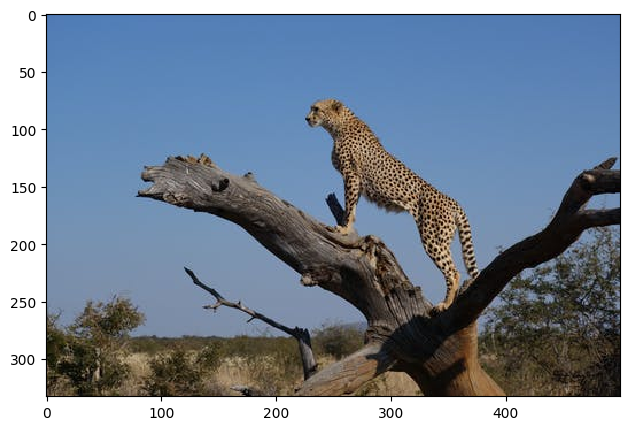

In [5]:
io.imshow(np.array(image_data[0]))

In [6]:
target_size = (max_width, max_height)
resized_images = [img.resize(target_size, Image.Resampling.LANCZOS) for img in image_data]

In [7]:
# Convert the data to numpy arrays
X = np.array(resized_images)
y = np.array(labels)
classes = set(y)

# Encode labels into numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

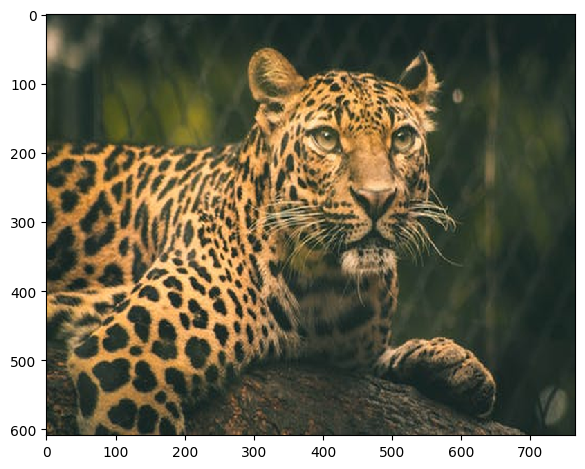

In [8]:
io.imshow(np.array(X_train[0]))

## Feature selection & dimensionality reduction

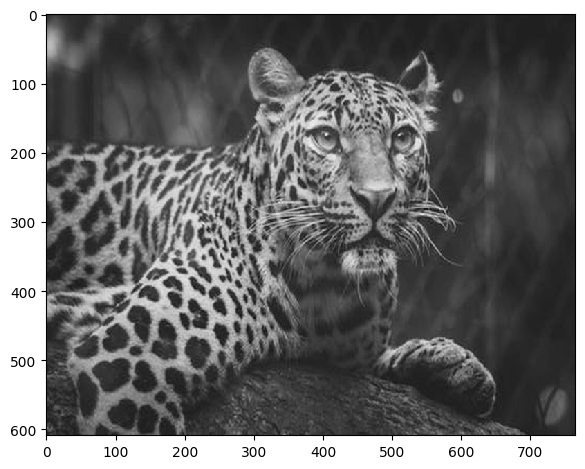

In [9]:
# Convert to grayscale
X_train_gs = [color.rgb2gray(img) for img in X_train]
X_test_gs = [color.rgb2gray(img) for img in X_test]
io.imshow(np.array(X_train_gs[0]))

### Fourier transform

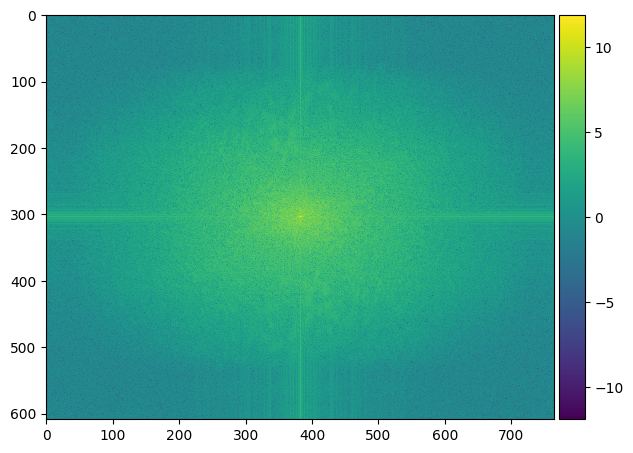

In [10]:
fft_images_train = [fourier_transform(img) for img in X_train_gs]
fft_images_test = [fourier_transform(img) for img in X_test_gs]
io.imshow(np.log(abs(fft_images_train[0])), cmap='viridis');

/home/madojo/AI/PR/assignment2/env/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


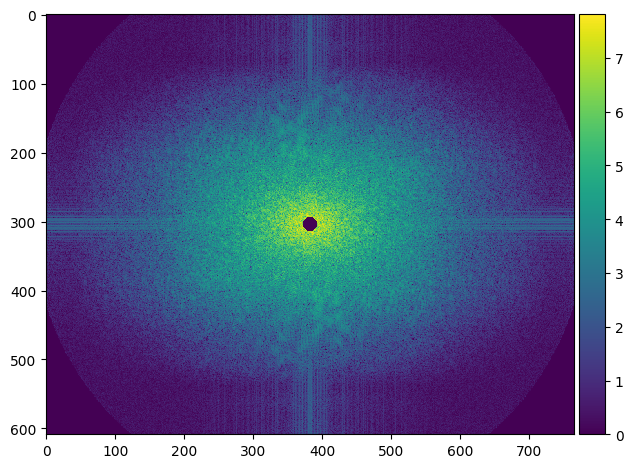

In [11]:
low_cutoff = 10
high_cutoff = 400
filtered_ftt_images_train = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_train]
filtered_ftt_images_test = [filter_fourier_image(img, low_cutoff, high_cutoff) for img in fft_images_test]
io.imshow(np.log(1+abs(filtered_ftt_images_train[0])), cmap='viridis');

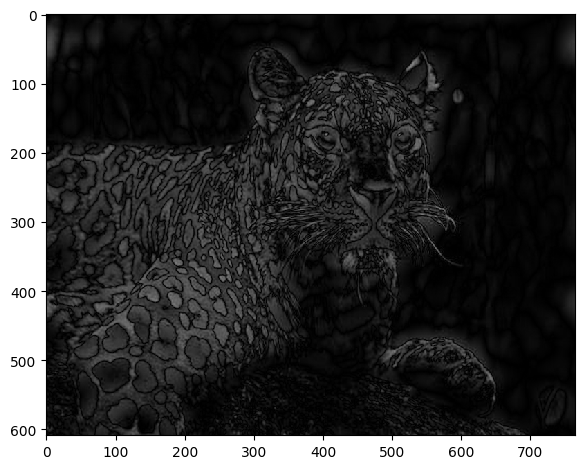

In [12]:
ifft_images_train = [inverse_fourier_transform(f) for f in filtered_ftt_images_train]
ifft_images_test = [inverse_fourier_transform(f) for f in filtered_ftt_images_test]
io.imshow(abs(ifft_images_train[0]), cmap='gray')

### SIFT (with bag-of-visual-words)

In [36]:
sift_features_train = sift_features(X_train_gs)
sift_features_test = sift_features(X_test_gs)

0 of 136
1 of 136
2 of 136
3 of 136
4 of 136
5 of 136
6 of 136
7 of 136
8 of 136
9 of 136
10 of 136
11 of 136
12 of 136
13 of 136
14 of 136
15 of 136
16 of 136
17 of 136
18 of 136
19 of 136
20 of 136
21 of 136
22 of 136
23 of 136
24 of 136
25 of 136
26 of 136
27 of 136
28 of 136
29 of 136
30 of 136
31 of 136
32 of 136
33 of 136
34 of 136
35 of 136
36 of 136
37 of 136
38 of 136
39 of 136
40 of 136
41 of 136
42 of 136
43 of 136
44 of 136
45 of 136
46 of 136
47 of 136
48 of 136
49 of 136
50 of 136
51 of 136
52 of 136
53 of 136
54 of 136
55 of 136
56 of 136
57 of 136
58 of 136
59 of 136
60 of 136
61 of 136
62 of 136
63 of 136
64 of 136
65 of 136
66 of 136
67 of 136
68 of 136
69 of 136
70 of 136
71 of 136
72 of 136
73 of 136
74 of 136
75 of 136
76 of 136
77 of 136
78 of 136
79 of 136
80 of 136
81 of 136
82 of 136
83 of 136
84 of 136
85 of 136
86 of 136
87 of 136
88 of 136
89 of 136
90 of 136
91 of 136
92 of 136
93 of 136
94 of 136
95 of 136
96 of 136
97 of 136
98 of 136
99 of 136
100 of 136

In [37]:
image_histograms_train = bag_of_visual_words(sift_features_train, 500)
image_histograms_test = bag_of_visual_words(sift_features_test, 500)

0 of 136
1 of 136
2 of 136
3 of 136
4 of 136
5 of 136
6 of 136
7 of 136
8 of 136
9 of 136
10 of 136
11 of 136
12 of 136
13 of 136
14 of 136
15 of 136
16 of 136
17 of 136
18 of 136
19 of 136
20 of 136
21 of 136
22 of 136
23 of 136
24 of 136
25 of 136
26 of 136
27 of 136
28 of 136
29 of 136
30 of 136
31 of 136
32 of 136
33 of 136
34 of 136
35 of 136
36 of 136
37 of 136
38 of 136
39 of 136
40 of 136
41 of 136
42 of 136
43 of 136
44 of 136
45 of 136
46 of 136
47 of 136
48 of 136
49 of 136
50 of 136
51 of 136
52 of 136
53 of 136
54 of 136
55 of 136
56 of 136
57 of 136
58 of 136
59 of 136
60 of 136
61 of 136
62 of 136
63 of 136
64 of 136
65 of 136
66 of 136
67 of 136
68 of 136
69 of 136
70 of 136
71 of 136
72 of 136
73 of 136
74 of 136
75 of 136
76 of 136
77 of 136
78 of 136
79 of 136
80 of 136
81 of 136
82 of 136
83 of 136
84 of 136
85 of 136
86 of 136
87 of 136
88 of 136
89 of 136
90 of 136
91 of 136
92 of 136
93 of 136
94 of 136
95 of 136
96 of 136
97 of 136
98 of 136
99 of 136
100 of 136

In [46]:
with open('image_histograms_train.pkl', 'wb') as file:
    pickle.dump(image_histograms_train, file)

with open('image_histograms_test.pkl', 'wb') as file:
    pickle.dump(image_histograms_test, file)

## Classification

### Original data

#### Logistic Regression     

In [54]:
lm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=2000))
lm.fit([x.flatten() for x in X_train], y_train)

# Make predictions
y_pred = lm.predict([x.flatten() for x in X_test])
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.29
F1 Score: 0.26


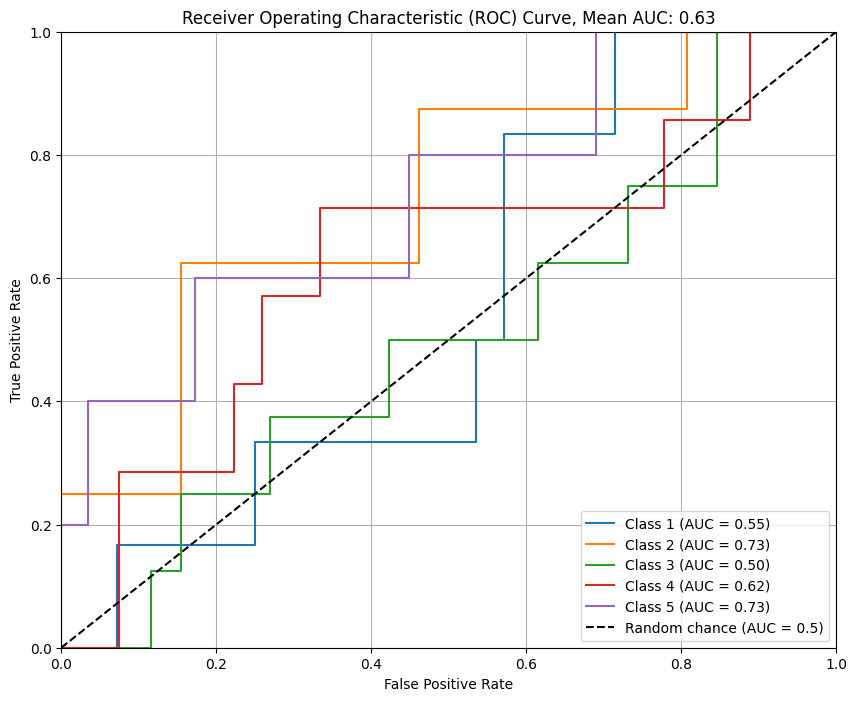

In [60]:
y_scores = lm.predict_proba([x.flatten() for x in X_test])
plot_ROC(y_test, y_scores)

#### Naive Bayes

In [61]:
gnb = GaussianNB()
gnb.fit([x.flatten() for x in X_train], y_train)
y_pred = gnb.predict([x.flatten() for x in X_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.18
F1 Score: 0.19


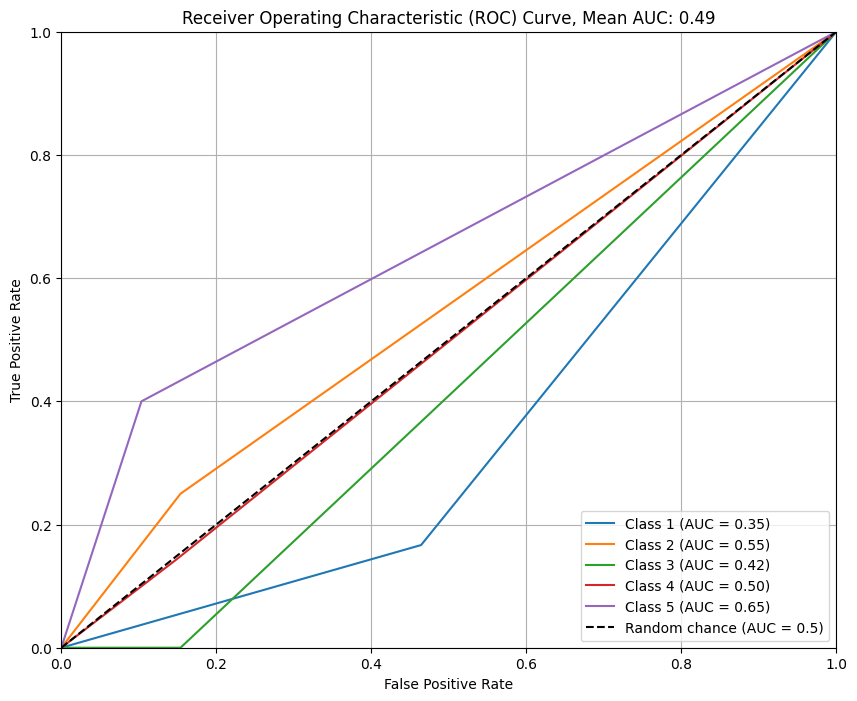

In [62]:
y_scores = gnb.predict_proba([x.flatten() for x in X_test])
plot_ROC(y_test, y_scores)

#### K-Nearest-Neighbours

In [63]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit([x.flatten() for x in X_train], y_train)
y_pred = knn.predict([x.flatten() for x in X_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.26
F1 Score: 0.25


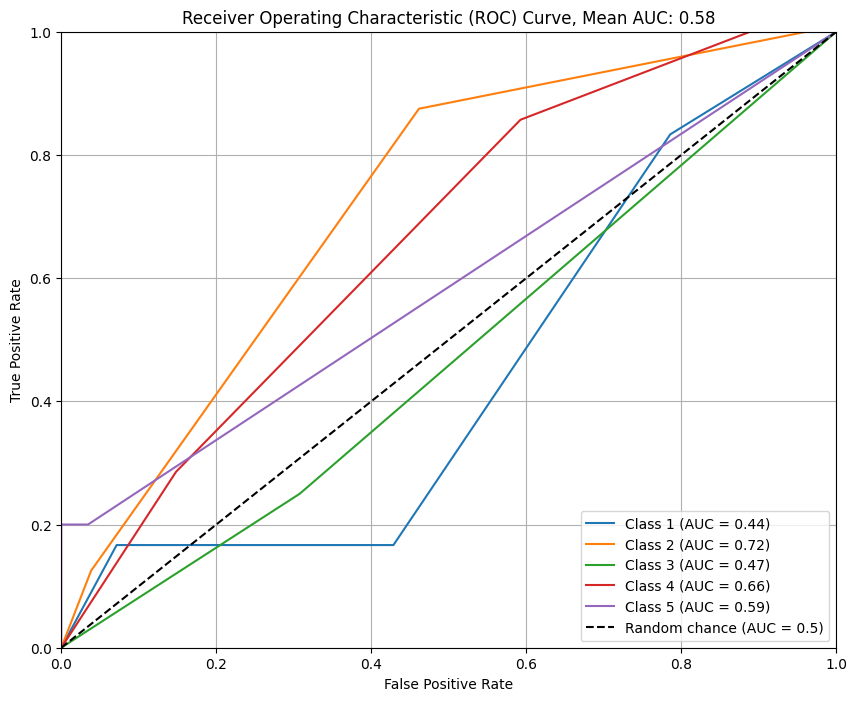

In [64]:
y_scores = knn.predict_proba([x.flatten() for x in X_test])
plot_ROC(y_test, y_scores)

### Fourier data 

#### Logistic Regression     

In [65]:
lm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=2000))
lm.fit([x.flatten() for x in ifft_images_train], y_train)

# Make predictions
y_pred = lm.predict([x.flatten() for x in ifft_images_test])
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.24
F1 Score: 0.21


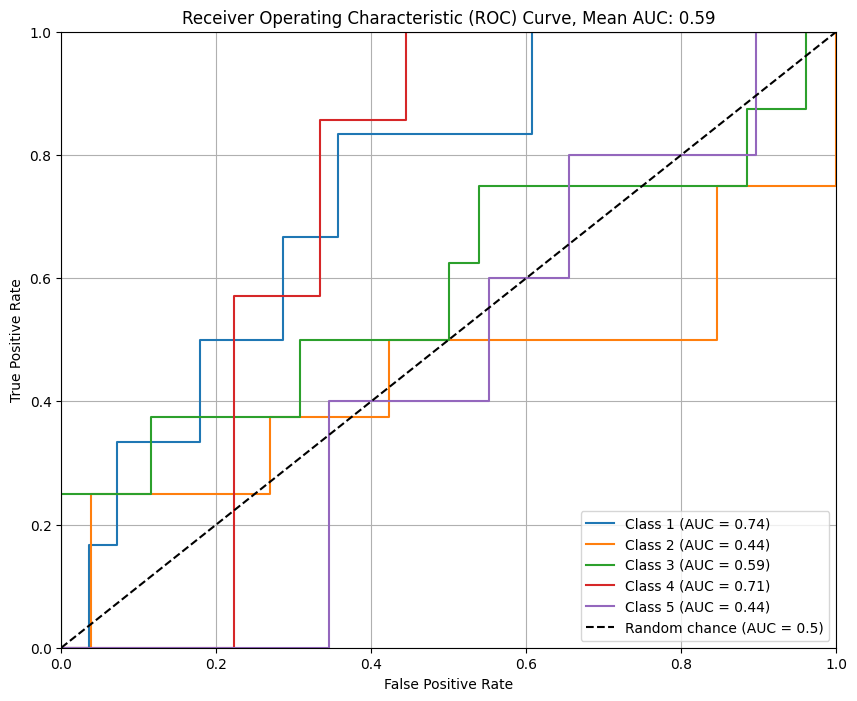

In [66]:
y_scores = lm.predict_proba([x.flatten() for x in ifft_images_test])
plot_ROC(y_test, y_scores)

#### Naive Bayes

In [67]:
gnb = GaussianNB()
gnb.fit([x.flatten() for x in ifft_images_train], y_train)
y_pred = gnb.predict([x.flatten() for x in ifft_images_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.35
F1 Score: 0.38


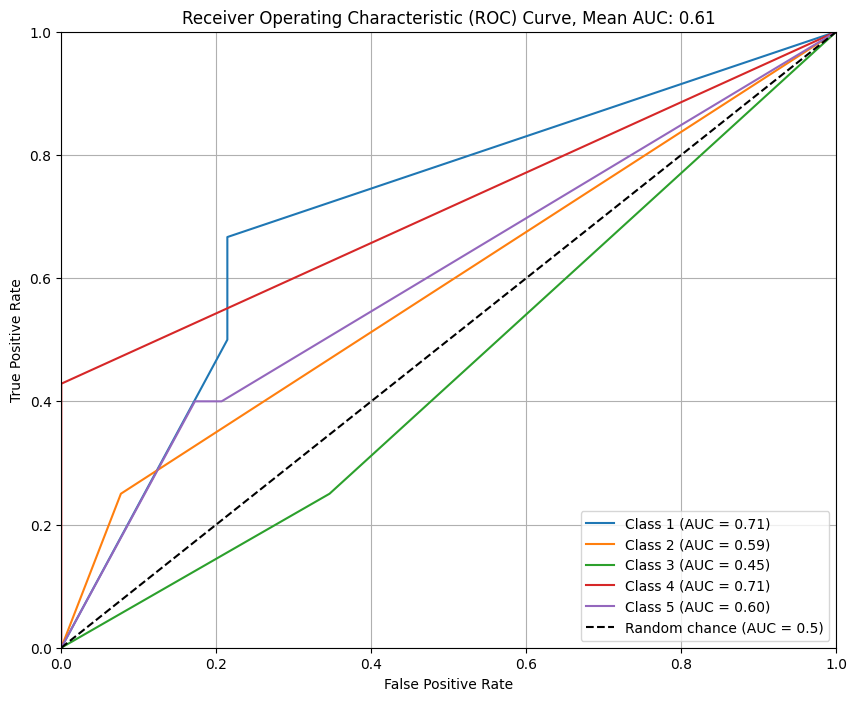

In [68]:
y_scores = gnb.predict_proba([x.flatten() for x in ifft_images_test])
plot_ROC(y_test, y_scores)

#### K-Nearest-Neighbours

In [69]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit([x.flatten() for x in ifft_images_train], y_train)
y_pred = knn.predict([x.flatten() for x in ifft_images_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.32
F1 Score: 0.25


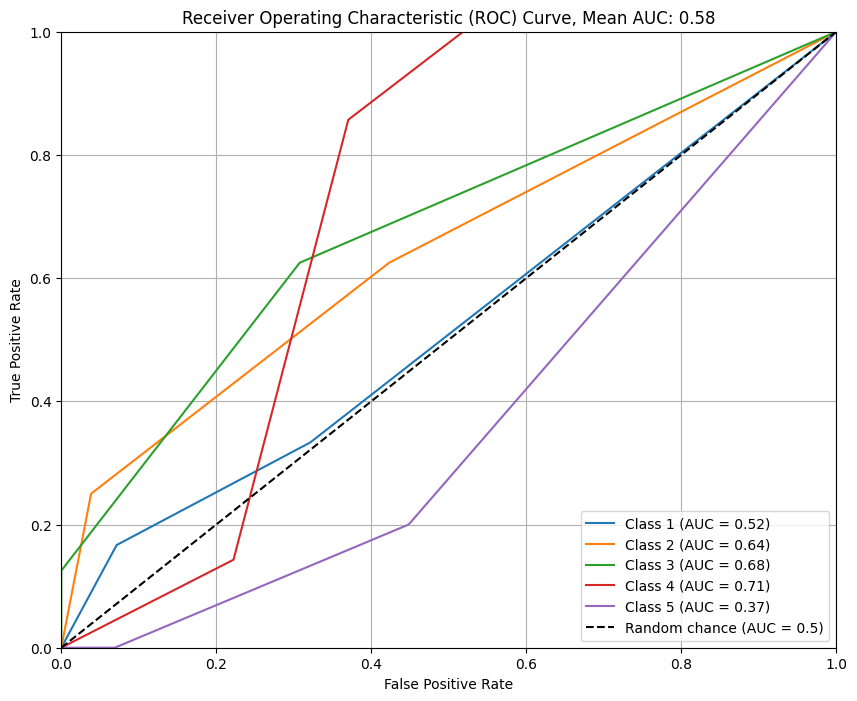

In [70]:
y_scores = knn.predict_proba([x.flatten() for x in ifft_images_test])
plot_ROC(y_test, y_scores)

### SIFT features

#### Logistic Regression     

In [71]:
lm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=5000))
lm.fit([x.flatten() for x in image_histograms_train], y_train)
y_pred = lm.predict([x.flatten() for x in image_histograms_test])

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.21
F1 Score: 0.16


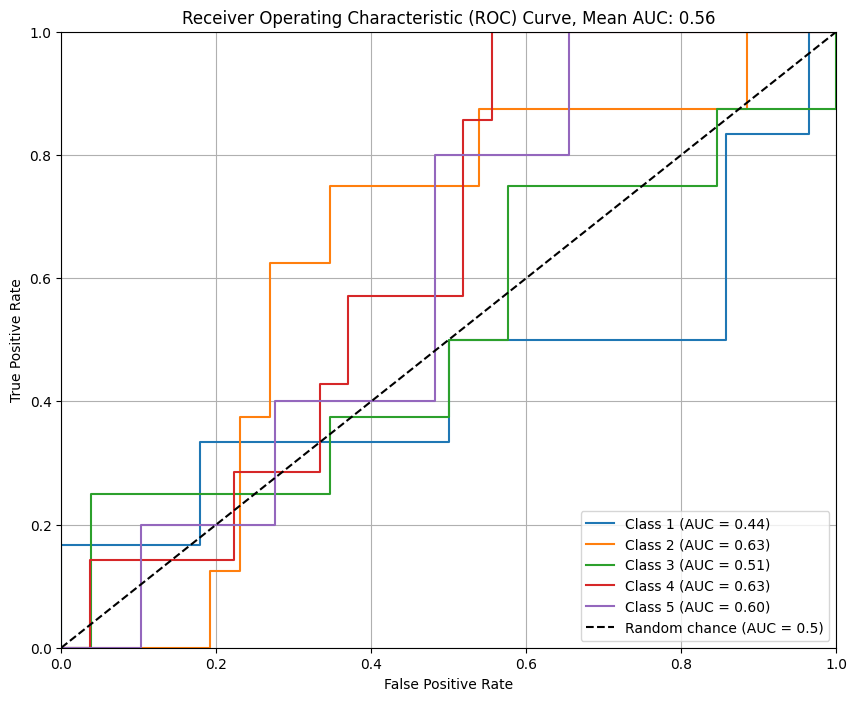

In [72]:
y_scores = lm.predict_proba([x.flatten() for x in image_histograms_test])
plot_ROC(y_test, y_scores)

#### Naive Bayes

In [73]:
gnb = GaussianNB()
gnb.fit([x.flatten() for x in image_histograms_train], y_train)
y_pred = gnb.predict([x.flatten() for x in image_histograms_test])

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.21
F1 Score: 0.14


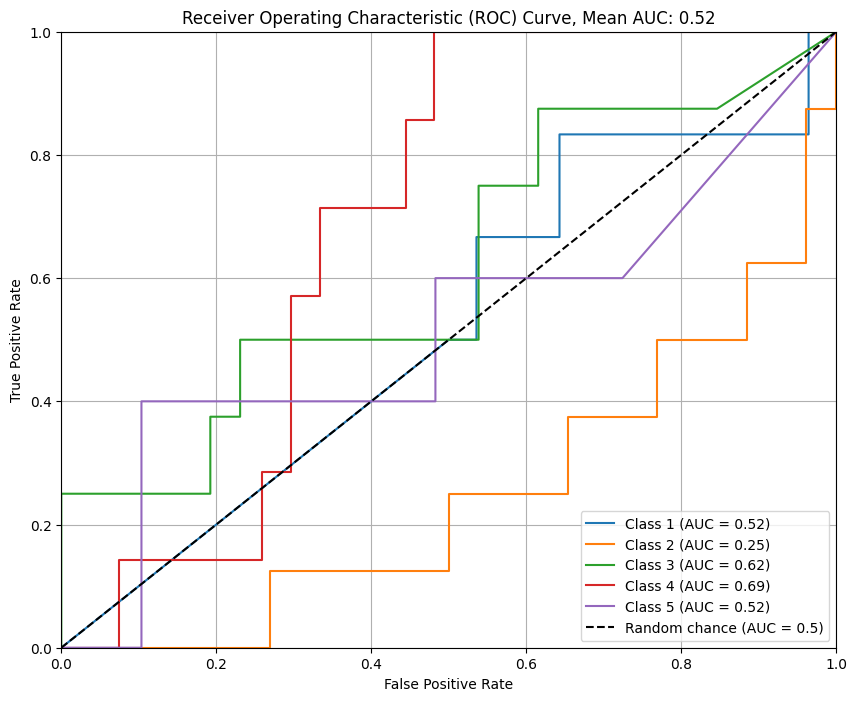

In [74]:
y_scores = gnb.predict_proba([x.flatten() for x in image_histograms_test])
plot_ROC(y_test, y_scores)

#### K-Nearest-Neighbours

In [75]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit([x.flatten() for x in image_histograms_train], y_train)
y_pred = knn.predict([x.flatten() for x in image_histograms_test])
# Make predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.21
F1 Score: 0.21


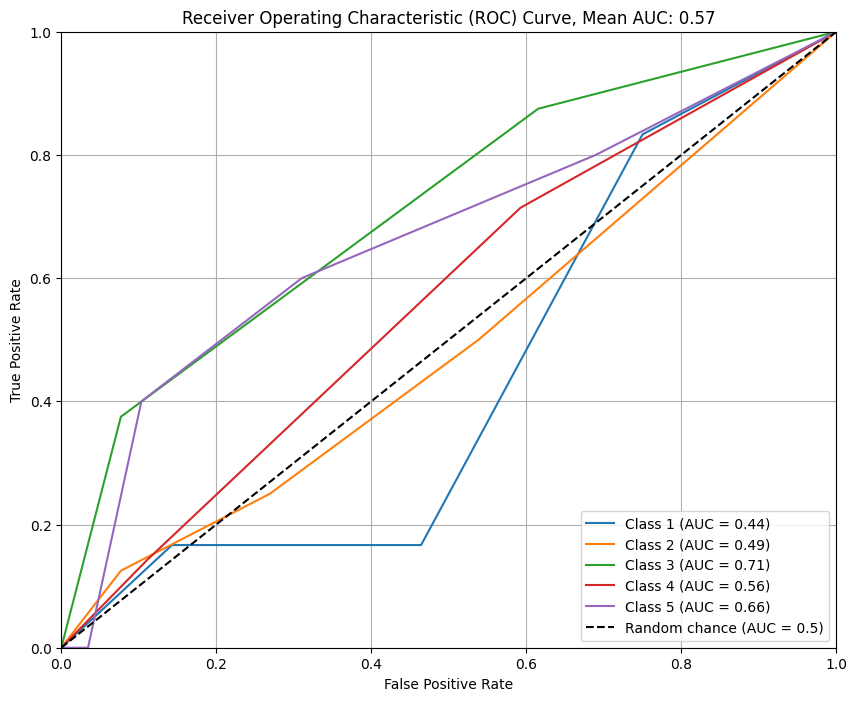

In [76]:
y_scores = knn.predict_proba([x.flatten() for x in image_histograms_test])
plot_ROC(y_test, y_scores)

## Clustering

Mean Silhouette Score for Fuzzy C-Means: 0.0234


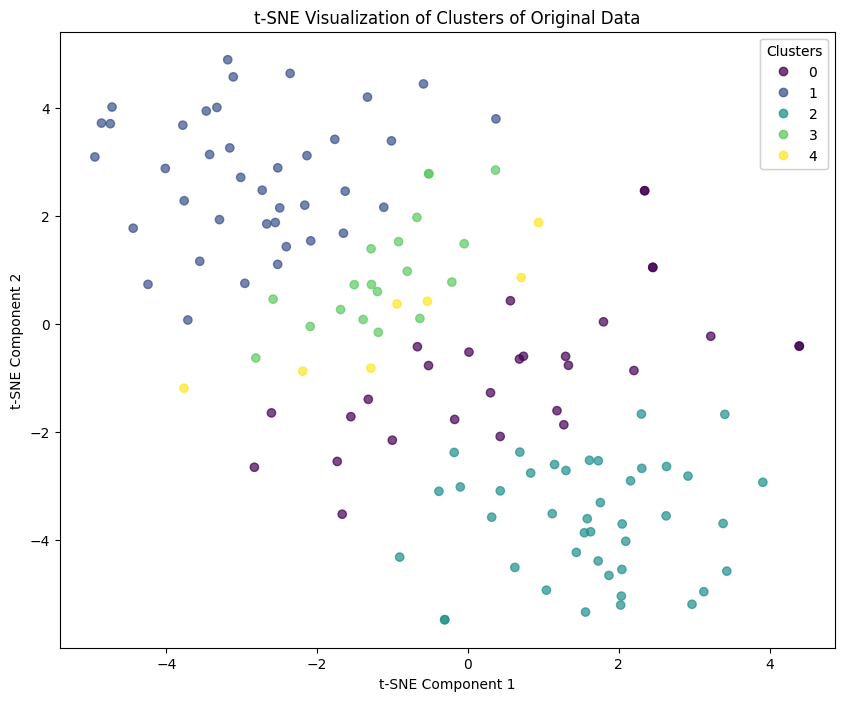

In [78]:
fuzzy_clustering([x.flatten() for x in X_train], "t-SNE Visualization of Clusters of Original Data")

Mean Silhouette Score for Fuzzy C-Means: 0.0649


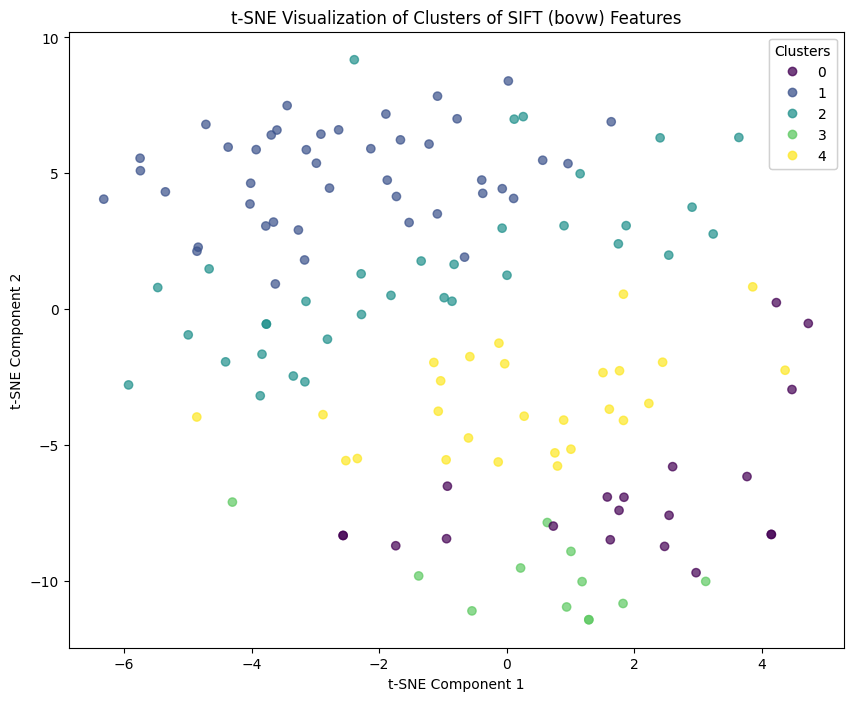

In [79]:
fuzzy_clustering([x.flatten() for x in image_histograms_train], "t-SNE Visualization of Clusters of SIFT (bovw) Features")

Mean Silhouette Score for Fuzzy C-Means: -0.0152


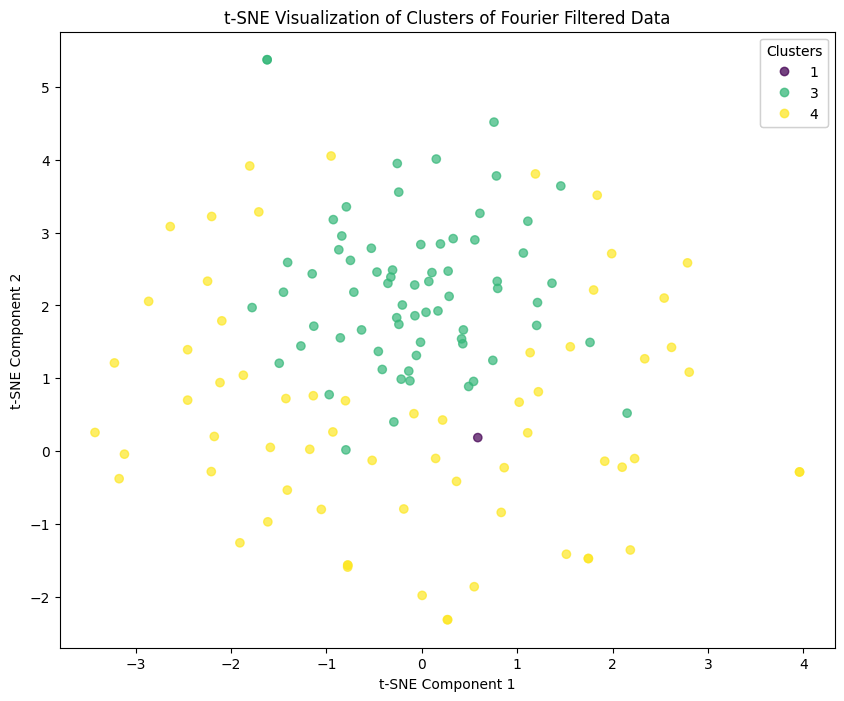

In [80]:
fuzzy_clustering([x.flatten() for x in ifft_images_train], "t-SNE Visualization of Clusters of Fourier Filtered Data")